# Object Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import models, layers, utils
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt

import numpy as np

In [3]:
img_size = (299, 299, 3)
dir_img_train = "dataset/subset/train/"
dir_img_validation = "dataset/subset/validation/"
dir_img_test = "dataset/subset/test/"
batch_size = 16
lr = 1e-4
epoch = 22

## Prepare Dataset

In [4]:
train_datagen = image.ImageDataGenerator(rescale=1. / 255,
                                         rotation_range=40,
                                         width_shift_range=0.2,
                                         height_shift_range=0.2,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(rescale=1. / 255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # target folder yang berisi kumpulan citra
    dir_img_train,
    # semua citra diubah ukurannya menjadi 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # class_mode categorical harus disesuaikan dengan fungsi loss
    # Karena fungsi loss yang digunakan adalah categorical crossentropy
    # maka class_mode = categorical
    class_mode="categorical",
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    dir_img_validation,
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=1234)

test_generator = test_datagen.flow_from_directory(dir_img_test,
                                                  target_size=img_size[:2],
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=1234)

Found 12000 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


## Mendefinisikan arsitektur model

In [6]:
def create_model():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = True

    input_layer = keras.Input(shape=img_size)
    x = conv_base(input_layer)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [7]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [8]:
# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           xception[1][0]                   
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 2048)         0           xception[1][0]                   
______________________________________________________________________________________________

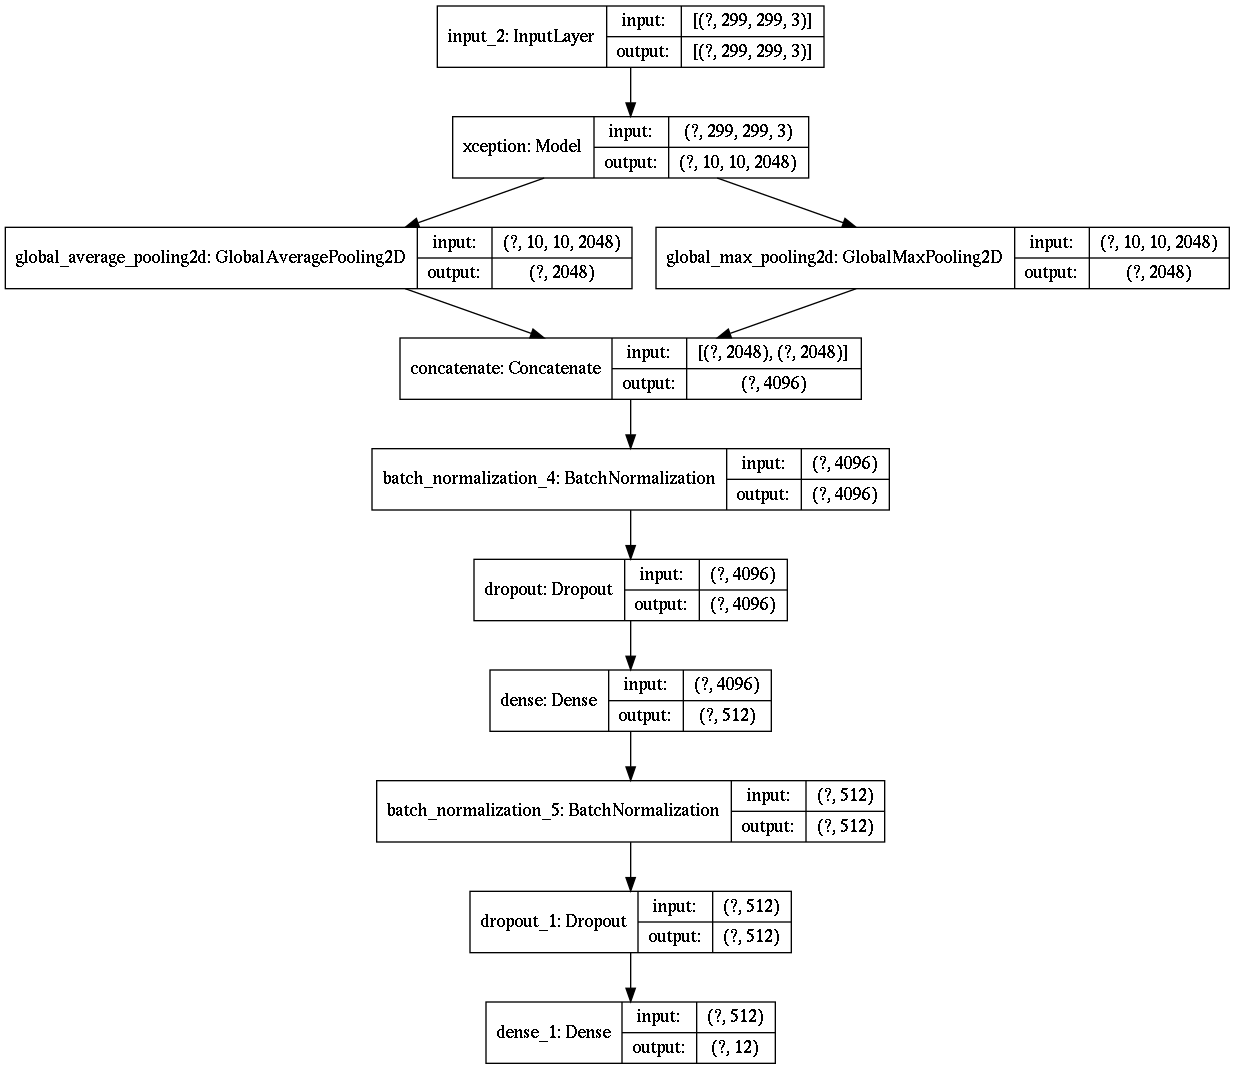

In [10]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Model

In [11]:
history = model.fit(train_generator,
                    epochs=epoch,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 75 steps
Epoch 1/22
750/750 [==============================] - 431s 575ms/step - loss: 1.5976 - categorical_accuracy: 0.5695 - val_loss: 0.7478 - val_categorical_accuracy: 0.7733
Epoch 2/22
750/750 [==============================] - 422s 563ms/step - loss: 1.0650 - categorical_accuracy: 0.6933 - val_loss: 0.6456 - val_categorical_accuracy: 0.8017
Epoch 3/22
750/750 [==============================] - 423s 564ms/step - loss: 0.8263 - categorical_accuracy: 0.7458 - val_loss: 0.6139 - val_categorical_accuracy: 0.8075
Epoch 4/22
750/750 [==============================] - 424s 565ms/step - loss: 0.6601 - categorical_accuracy: 0.7947 - val_loss: 0.6161 - val_categorical_accuracy: 0.8075
Epoch 5/22
750/750 [==============================] - 423s 564ms/step - loss: 0.5083 - categorical_accuracy: 0.8389 - val_loss: 0.6237 - val_categorical_accuracy: 0.8158
Epoch 6/22
750/750 [==============================] - 423

In [12]:
model.metrics_names

['loss', 'categorical_accuracy']

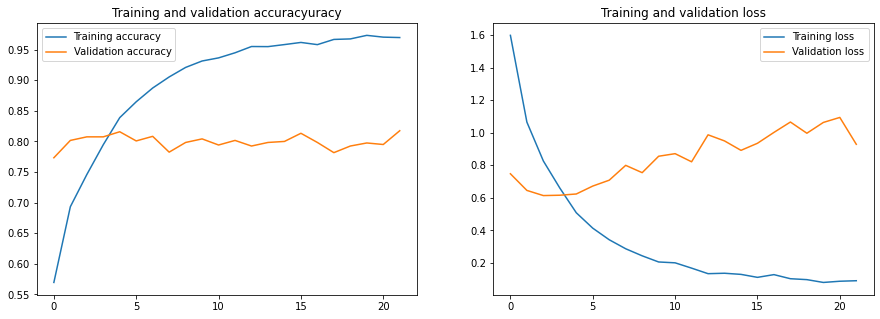

In [13]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate Model

In [14]:
model.evaluate(validation_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 10s 133ms/step - loss: 0.9288 - categorical_accuracy: 0.8175


[0.9288075790305932, 0.8175]

In [15]:
y_true = list()
for idx in range(len(validation_generator.index_array)):
    img_idx = validation_generator.index_array[idx]
    y_true.append(validation_generator.labels[img_idx])

In [16]:
y_pred_prob = model.predict(validation_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 10s 130ms/step


In [17]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.96      0.94      0.95       100
     cabinet       0.84      0.79      0.81       100
       chair       0.83      0.74      0.78       100
 coffe_maker       0.81      0.79      0.80       100
         fan       0.88      0.84      0.86       100
      kettle       0.78      0.83      0.80       100
        lamp       0.79      0.72      0.75       100
         mug       0.81      0.90      0.85       100
        sofa       0.94      0.88      0.91       100
     stapler       0.84      0.89      0.86       100
       table       0.65      0.62      0.63       100
     toaster       0.72      0.87      0.79       100

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200



In [18]:
model.save("end_to_end_learning_without_frozen_layer.h5")